In [280]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
# import numba
from numba import njit
import plotly.graph_objects as go
import h5py
import glob
from scipy.optimize import newton, curve_fit
from scipy.signal import find_peaks

# Helper functions

In [281]:
def extract_data(h5_filepath, dims, begin = 0, end = 1, nVars = 38):
    if type(dims) == list:
        dims = np.array(dims)

    with h5py.File(h5_filepath,'r') as h5f:
        keys = list(h5f.keys())
        test = h5f[keys[-1]]
        keys = list(test.keys())
        
        # boxDims = test[keys[1]][()]
        # # print(boxDims)
        domain_decomp = test[keys[1]][()]
        data = test[keys[2]][()]
    
    output = np.zeros((end - begin, *dims))
    decomp_box_size = [int(domain_decomp[0][5]-domain_decomp[0][2]+1),
                       int(domain_decomp[0][4]-domain_decomp[0][1]+1),
                       int(domain_decomp[0][3]-domain_decomp[0][0]+1)]
    sz = 1
    for i in decomp_box_size: sz *= i
    revdims = np.flip(dims)

    for i in range(begin, end):
        currVar = np.zeros(revdims)
        for j in range(0, len(domain_decomp)):
            curr_decomp = domain_decomp[j]
            slc = np.s_[curr_decomp[2]:curr_decomp[5]+1, curr_decomp[1]:curr_decomp[4]+1, curr_decomp[0]:curr_decomp[3]+1]
            currVar[slc] = data[(i + j*nVars)*sz:(i+1 + j*nVars)*sz].reshape(*decomp_box_size)
    
        output[i - begin] = np.moveaxis(currVar, [0, -1], [-1, 0])

    return output

In [282]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    cs2 = 1/3
    return -out/cs2

def model_cs2(density, C0):
    return T

def cs2k(kx, ky, kz, density, C0):
    thermal_cs2 = model_cs2(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    return thermal_cs2 + k2*kappa*density

# def mu_c(density, C0):
#     # return (-T*density*np.log((density - C0)/C0) - Lambda*(2.*C0 - density))/(2.*density)
#     return (-C0*chi*(C0 - density) - T*np.power(density, 2)/2)/(C0*density*(C0 - density))

def mu_c(rho0, phi0):
    return (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))/(2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))

def mu_ck(kx, ky, kz, density, C0):
    ref_state = mu_c(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = ref_state + kappa*k2
    else:
        out = ref_state
    return out

In [283]:
def spherically_averaged_structure_factor(data, density, C0, scale_factor = 1, func = None, shift = True, cs = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    # test[slc] /= test.sum()
    # S[L//2, L//2, L//2] /= S.sum()

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [284]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, C0, radius = 1, scale_factor = 1, func = None, cs = True):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor
    # S[L//2, L//2, L//2] /= S.sum()
    
    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [285]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

# Validation

## Homogeneous system

In [286]:
L = 16
binsize = 6
correlated = True

kappa = 0.01
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0
chi = 0.4
T = 0.25
rho0 = 1.0
phi0 = 0.0

idx = -1
# savedir = f"./k_{kappa}/"
savedir = f"./"
slc = np.s_[L//2, L//2, L//2]

In [287]:
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

yt : [INFO     ] 2024-09-16 17:12:11,233 Parameters: current_time              = 3500.0
yt : [INFO     ] 2024-09-16 17:12:11,235 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-09-16 17:12:11,236 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-09-16 17:12:11,237 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


In [288]:
ds.field_list

[('boxlib', 'struct_fact_density_density'),
 ('boxlib', 'struct_fact_density_phi'),
 ('boxlib', 'struct_fact_density_ux'),
 ('boxlib', 'struct_fact_density_uy'),
 ('boxlib', 'struct_fact_density_uz'),
 ('boxlib', 'struct_fact_phi_phi'),
 ('boxlib', 'struct_fact_phi_ux'),
 ('boxlib', 'struct_fact_phi_uy'),
 ('boxlib', 'struct_fact_phi_uz'),
 ('boxlib', 'struct_fact_ux_ux'),
 ('boxlib', 'struct_fact_ux_uy'),
 ('boxlib', 'struct_fact_ux_uz'),
 ('boxlib', 'struct_fact_uy_uy'),
 ('boxlib', 'struct_fact_uy_uz'),
 ('boxlib', 'struct_fact_uz_uz')]

### Density

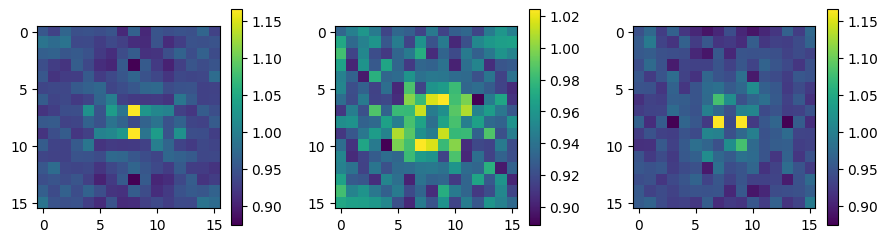

In [289]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)
experiment_muck = cs2k(kx, ky, kz, 1.0, 0.0)
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]

test = data[0].copy()
# test[slc] = (test.sum() - test[slc])/(L**3)
# test[slc] *= kbt/(L**3*T)
test /= kbt

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
test *= (experiment_muck)
# test[slc] /= test.sum()
test[slc] = (test.sum() - test[slc])/(L**3)
im = ax.imshow(test[L//2, :, :])
plt.colorbar(im, ax = ax, shrink = 0.8)

ax = axs[1]
im = ax.imshow(test[:, L//2, :])
plt.colorbar(im, ax = ax, shrink = 0.8)

ax = axs[2]
im = ax.imshow(test[:, :, L//2])
plt.colorbar(im, ax = ax, shrink = 0.8)

fig.tight_layout()

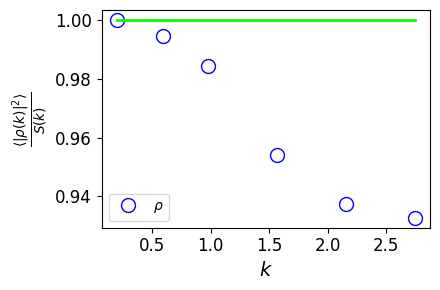

In [290]:
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]
slc = np.s_[L//2, L//2, L//2]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1
# scale_factor = cs2

for d in data:
        d /= kbt
        # d[slc] = (d.sum() - d[slc])/(L**3)
        d[slc] /= (L**3*T)/kbt
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.95, 1.05])
fig.tight_layout()
# fig.savefig("./equilibration_ratio.svg")

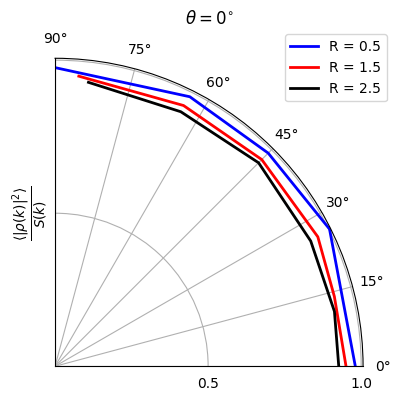

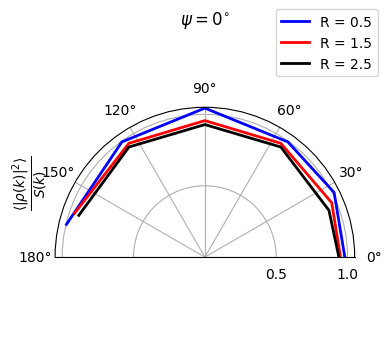

In [291]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### C1

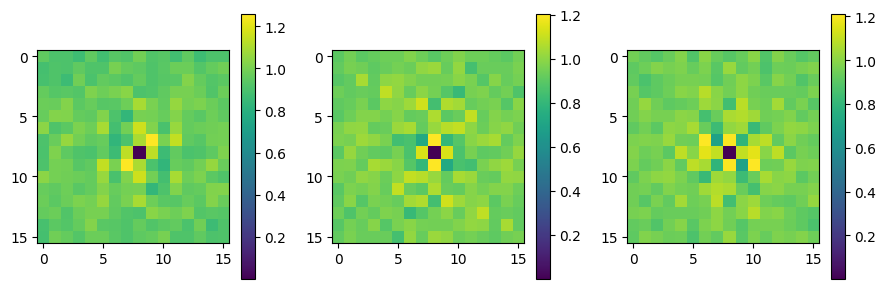

In [298]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)
experiment_muck = mu_ck(kx, ky, kz, 1.0, 0.0)
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

test = data[0].copy()
# test[slc] = (test.sum() - test[slc])/(L**3)

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
# test[slc] = (test.sum() - test[slc])/L**3
test *= (experiment_muck)
test /= kbt
test[slc] /= test.sum()

im = ax.imshow(test[L//2, :, :])
plt.colorbar(im, ax = ax)

ax = axs[1]
im = ax.imshow(test[:, L//2, :])
plt.colorbar(im, ax = ax)

ax = axs[2]
im = ax.imshow(test[:, :, L//2])
plt.colorbar(im, ax = ax)

fig.tight_layout()

In [299]:
data[0][slc]

2.6090955222390693e-06

(0.95, 1.05)

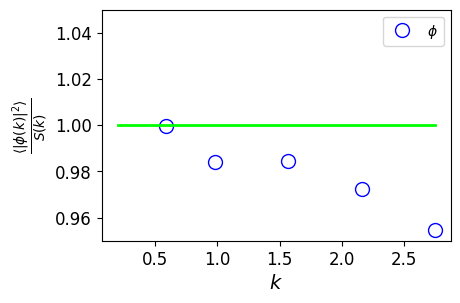

In [293]:
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\phi$"]

rho_func = lambda a, c: a*c
scale_factor = 1

for d in data:
        d /= kbt
        d[slc] = (d.sum() - d[slc])/L**3
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = scale_factor, func = rho_func, cs = False)
        x, y = make_bins(x, binsize, to_bin2 = y)
        # y[0] = 1
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# print(x, y)
ax.set_ylim([0.95, 1.05])

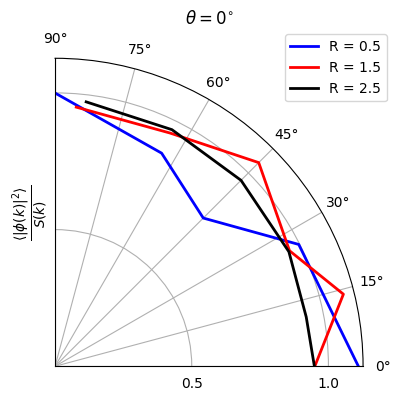

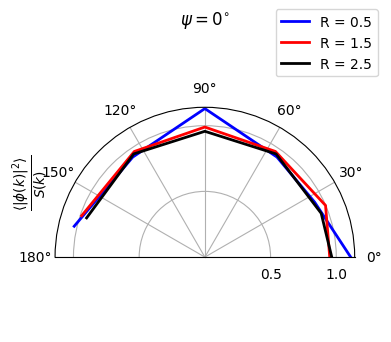

In [294]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r, func=rho_scale, scale_factor = scale_factor, cs = False)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### Velocities

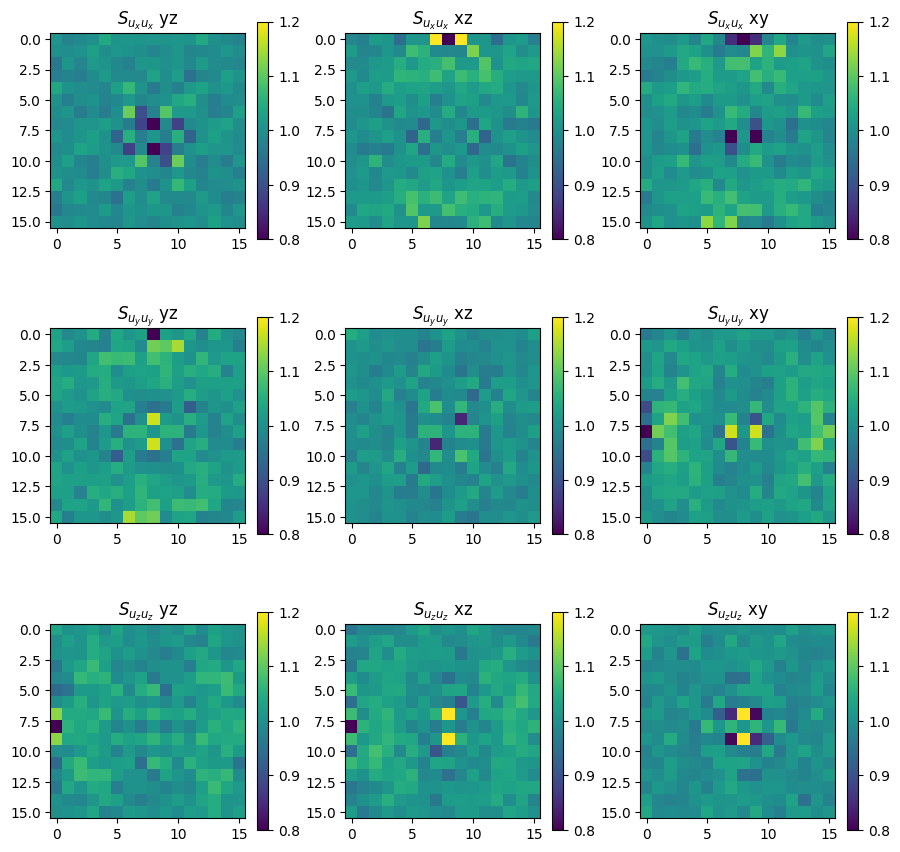

In [295]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

slc_s = [np.s_[L//2, :, :], np.s_[:, L//2, :], np.s_[:, :, L//2]]
labels = ['yz', 'xz', 'xy']
fig, axs = plt.subplots(3, 3, figsize = (9, 9))

for i in range(3):
    d = data[i]
    d[slc] = (d.sum() - d[slc])/(L**3)
    d /= kbt
    for j in range(3):
        ax = axs[i, j]
        im = ax.imshow(d[slc_s[j]], vmin = 0.8, vmax = 1.2)
        plt.colorbar(im, ax = ax, shrink = 0.8)
        ax.set_title(f"$S_{{u_{chr(120+i)}u_{chr(120+i)}}}$ {labels[j]}")

fig.tight_layout()

(0.95, 1.05)

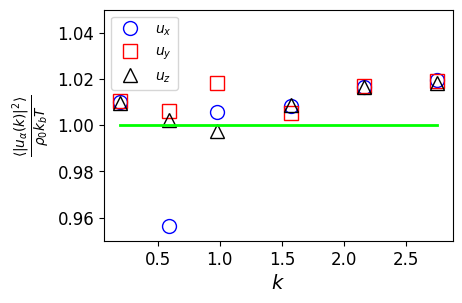

In [296]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i, d in enumerate(data):
        # d[slc] *= L**3
        # d[slc] /= 3*kbt
        d[slc] = (d.sum() - d[slc])/(L**3)
        d /= kbt
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = 1)
        x, y = make_bins(x, binsize, to_bin2 = y)

        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])
ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_{0}k_b T}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
ax.set_ylim([0.95, 1.05])

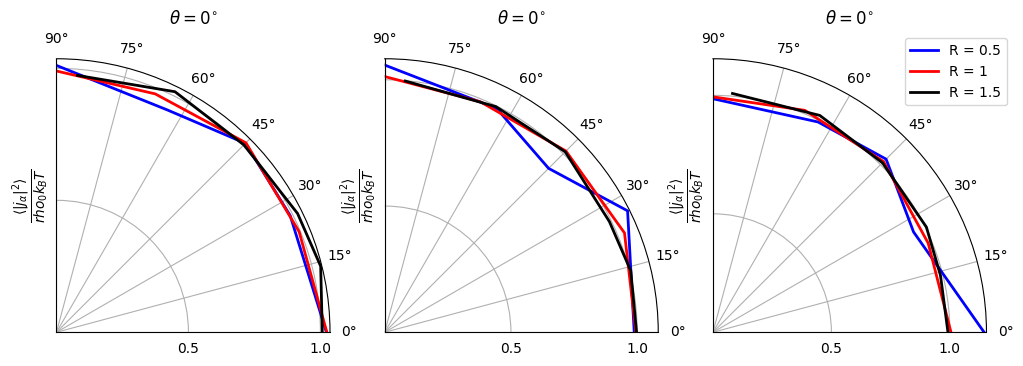

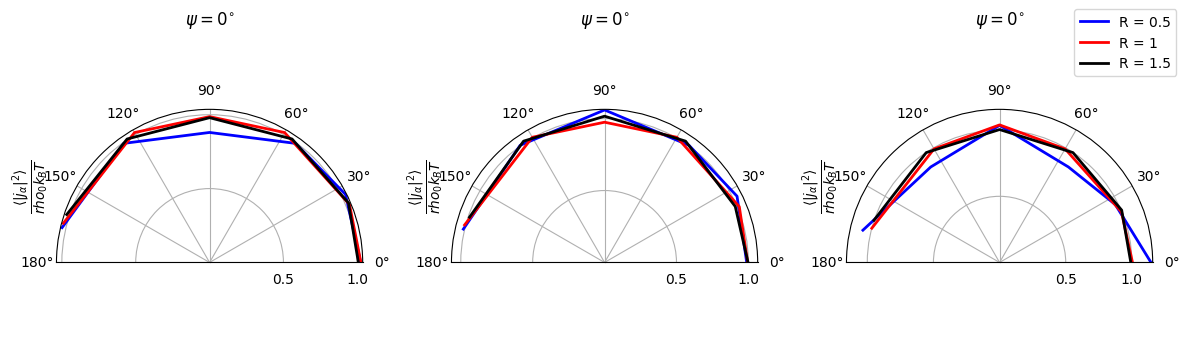

In [297]:
sz = 4
fig, tax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1, 1.5]

t_angle = 0
p_angle = 0 
# binsize = 10

for j, d in enumerate(data):
    ax1 = tax[j]
    ax2 = pax[j]
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)

fig.tight_layout()

## Interfacial fluctuations

In [ ]:
chi = 1.1
k = 0.03
T = 0.5


X, Y, Z = np.meshgrid(*[np.linspace(0, 29, 30), np.linspace(0, 5, 6), np.linspace(0, 64, 64)])

# phi_test = np.zeros()


# # x = np.linspace(0, nx - 1, nx)
b = -(chi**2.350)/(k**0.640 * T**5.559*489.435)
c = 0.5
phi = c*np.tanh(b*(X - (30 - 1)/2))

# plt.plot(x, y, 'rx')
plt.imshow(phi[3, :, :])

In [ ]:
yk = fft.fftn(phi)
wk = fft.fftfreq(y.size)

In [ ]:
plt.imshow(yk.real[:, 15, :])
plt.colorbar()

In [ ]:
yk[3, 12,]

In [ ]:
wk = fft.fftfreq(y.size)
yk_analytical = np.sqrt(np.pi/2)*c/(np.sinh(np.pi*(2*np.pi*wk)/(2*b))*np.abs(b))*1j*5

np.abs(yk_analytical[-1]), np.abs(yk[-1])
# for i in range(y.size):
#     print(f"{yk[i]} {yk_analytical[i]}")

In [ ]:
def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))

x = np.linspace(-1, 1, 1001)
l = 1.1
T = 0.50

y = fb(x, l, T)

plt.plot(x, y)
plt.plot([x[0], x[-1]], [0, 0], 'r')

newton(fb, x0 = (0.6), args = (l, T))

In [ ]:
# %%capture
@njit
def func_mu_rho(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 4) - chi*np.power(phi0, 4) + chi*np.power(phi0*rho0, 2))
    denominator = (2.*np.power(rho0, 3)*(np.power(phi0, 2) - np.power(rho0, 2)))
    out = numerator/denominator + k2*kappa
    return out

@njit 
def func_mu_phi(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))
    denominator = (2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))
    # print(numerator, denominator)
    out = numerator/denominator + k2*kappa
    return out

L = 16
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)

k2 = np.unique(np.round(k2, 1))
phi_s = np.linspace(-0.90, 0.90, k2.size)
rho_s = np.linspace(0.995, 1.005, k2.size)

kappa_set = 0.03
chi_set = 1.1
T_set = 0.5

K2, PHIS = np.meshgrid(*[k2, phi_s])
MUPHI = np.zeros_like(K2)
K2, RHOS = np.meshgrid(*[k2, rho_s])
MURHO = np.zeros_like(K2)

for i in range(k2.size):
    for j in range(k2.size):
        MUPHI[i,j] = func_mu_phi(1, PHIS[i, j], T_set, chi_set, K2[i, j], kappa_set)
        MURHO[i,j] = func_mu_rho(1, RHOS[i, j], T_set, chi_set, K2[i, j], kappa_set)

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
im = ax.pcolor(K2,PHIS,MUPHI, vmin = -0.01, vmax = 0.01)
plt.colorbar(im, ax = ax, label = r"$\mu_{\phi}$", orientation = 'horizontal')
ax.set_xlabel("k2")
ax.set_ylabel(r"$\phi$")

ax.set_title(f"T = {T_set}, $\chi$ = {chi_set}")
fig.tight_layout()

ax = axs[1]
im = ax.pcolor(K2,RHOS,MURHO, vmin = -0.01, vmax = 0.01)
plt.colorbar(im, ax = ax, label = r"$\mu_{\rho}$", orientation = 'horizontal')
ax.set_xlabel("k2")
ax.set_ylabel(r"$\rho$")

ax.set_title(f"T = {T_set}, $\chi$ = {chi_set}")
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (9, 3))

kappa_s = [0.01, 0.02, 0.03]
b_k = [-2.312, -1.5426, -1.1367]

chi_s = [1.1, 1.2, 1.3]
b_chi = [-2.312, -3.0679, -3.4158]

T_s = [0.48, 0.5, 0.52]
b_T = [-2.6976, -2.314, -1.7270]

ax = axs[0]
x = np.array(kappa_s)
y = np.array(b_k)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$\kappa$")
ax.set_ylabel(r"$b$")

ax = axs[1]
x = np.array(chi_s)
y = np.array(b_chi)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$\chi$")
ax.set_ylabel(r"$b$")

ax = axs[2]
x = np.array(T_s)
y = np.array(b_T)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$b$")

fig.tight_layout()

In [ ]:
import sympy as sp
from sympy import integrate

rho, phi0, chi, kappa, T, x, b = sp.symbols(r"\rho, \phi_0, \chi, \kappa, T, x, b")

phi = phi0*sp.tanh(b*x)

excess = chi/4*(1 - (phi/rho)**2) - T*rho + T/2*(rho + phi)*sp.log((rho + phi)/2) + T/2*(rho - phi)*sp.log((rho - phi)/2)
excess = excess.subs({rho:1}).simplify()

part1_excess = integrate(excess, (x, -sp.oo, sp.oo)).doit()

In [ ]:
integrate(sp.tanh(x), x)

In [ ]:
part1_excess

In [ ]:
def interface_height(density, chi, T):
    fit_func = lambda x, b, c: newton(fb, x0 = (0.5), args = (chi, T))*np.tanh(b*(x - c))
    nx, ny, nz = density.shape
    lo_min = nx//4
    hi_max = 3*(nx//4)

    test = density[lo_min:hi_max, :, :]
    x = np.linspace(0, test.shape[0] - 1, test.shape[0])
    height_func = np.zeros(test.shape[1:])

    for y in range(test.shape[1]):
        for z in range(test.shape[2]):
            slc = test[:, y, z]
            popt, pcov = curve_fit(fit_func, x, slc, p0 = [-1, x[x.size//2]])
            # slc_grad = np.abs(np.gradient(slc))
            # peak_idx = find_peaks(slc_grad, prominence=0.08)[0][0]
            height_func[y, z] = popt[-1] + nx//4
    return height_func

In [ ]:
import scipy.stats as stats

# fig, axs = plt.subplots(1, 2, figsize = (9, 3))
f, (ax1, ax2) = plt.subplots(1, 2,  figsize = (10, 5), gridspec_kw={'width_ratios': [3, 2]})
# color = [""]
chi = 1.1
T = 0.5
z = 64
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)
# mu = 0
# sigma = np.std(h)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# ax2.plot(x, stats.norm.pdf(x, mu, sigma), label = f"z = {z}")

z = 128
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

z = 256
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

z = 512
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

ax1.legend(ncols = 2)
ax2.legend()
fig.tight_layout()

In [ ]:
nx = 20
ny = 2
nz = 256
boxDim = np.array([nx, ny, nz])

chi = 1.1
T = 0.50
k = 0.03
# profile = extract_data(savedir + sorted(glob.glob("./*.h5"))[-1], [nx, ny, nz], begin = 1, end = 2, nVars = 38)
profile = extract_data(sorted(glob.glob("./*.h5"))[-1], boxDim, begin = 1, end = 2, nVars = 38)

fit_func = lambda x, b, c: newton(fb, x0 = (0.6), args = (chi, T))*np.tanh(b*(x - c))

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
im = ax.imshow(profile[0, :, : , nz//2])
plt.colorbar(im, ax = ax)

ax = axs[1]
x = np.arange(nx//4, 3*nx//4, 1)
im = ax.plot(x, profile[0, nx//4:3*nx//4, ny//2 , nz//2], 'rx', label = "profile")
popt, pcov = curve_fit(fit_func, x, profile[0, nx//4:3*nx//4, ny//2 , nz//2], p0 = [-1, x[x.size//2]])
xfit = np.linspace(x.min(), x.max(), 101)
ax.plot(xfit, fit_func(xfit, *popt), label = "fit")

# x = np.linspace(0, nx - 1, nx)
b = -(chi**2.350)/(k**0.640 * T**5.559*489.435)
y = newton(fb, x0 = (0.6), args = (chi, T))*np.tanh(b*(x - (nx - 1)/2))

ax.plot(x, y, 'ko', label = "profile prediction", markerfacecolor="None")
ax.legend(ncol = 1, fontsize = 'small')

fig.suptitle(r"$\kappa$ = 0.01, $\chi = 1.1, T = 0.52$")
fig.tight_layout()
print(popt)

In [ ]:
# nx = 16
# ny = 6
# nz = 64
nx = 20
ny = 2
nz = 256

boxDim = np.array([nx, ny, nz])

binsize = 10
correlated = True

kappa = 0.01
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0
chi = 1.1
T = 0.50
rho0 = 1.0
phi0 = 0.0

idx = -1
# savedir = f"./2D_int/L_{nz}/"
# savedir = f"./interface/L_{nz}/"
savedir = f"./"

In [ ]:
heights_k = np.zeros((nz), dtype = np.complex128)

h5_paths = sorted(glob.glob(savedir + "/*.h5"))[100:]

for path in h5_paths:
    phi = extract_data(path, boxDim, begin = 1, end = 2, nVars = 38)
    h = interface_height(phi[0, :, :, :], chi, T)
    # h = np.mean(h, axis = 0)
    h_k = fft.fft(h)
    h_k = np.mean(h_k, axis = 0)

    heights_k += h_k*h_k.conjugate()
    t = int(path.split("/")[-1].split(".")[0].split("_")[-1])
    print(f"Timestep {t} processed")

heights_k = np.abs(heights_k)
heights_k /= len(h5_paths)
# heights_k /= nx*ny*nz

In [ ]:
## k averaging
L = nz

k1 = fft.fftfreq(L)*2*np.pi
S1 = heights_k.copy()

kmin = 2*np.pi/L
where = np.s_[:]#np.where(k1<=kmax)
bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1

shells = np.histogram(k1[where], bins, weights=S1[where])[0]
counts = np.histogram(k1[where], bins)[0]

x_t = (bins[:-1]+bins[1:])/2
y_t = shells/counts
## k averaging
# L = nz
# x_t = np.abs(fft.fftfreq(L)*2*np.pi)
# y_t = heights_k.copy()

# idxs = np.argsort(x_t)
# x_t = x_t[idxs]
# y_t = y_t[idxs]

fig, ax = plt.subplots(1, 1, figsize = (4, 3))

ax.loglog(x_t[1:], y_t[1:]/40, "bx", label = "Simulation")
ax.set_xlabel(r"$k$", fontsize = 15)
ax.set_ylabel(r"$\langle |h(k)|^2 \rangle$", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)

# sigma = 5.392e-3
sigma = 5.295e-3
# sigma = 1.128e-2
# freqs_theory = np.arange(nx//2 + 1)*2*np.pi/nx
freqs_theory = np.linspace(x_t[1:][0], x_t[1:][-1], 1001)
interface_fluct_theory = kbt/(sigma*np.power(freqs_theory, 2))

ax.loglog(freqs_theory, interface_fluct_theory, 'r-', lw = 2, label = "Theory")
ax.legend(fontsize = 12)
# ax.set_xlim([10**-3, 4])
# ax.set_ylim([10**-6, 10**-1])
ax.set_title(f"L = {nz}")
fig.tight_layout()

# Valid variable range

From the covariance matrix, certain limits on parameter values are set based upon ensuring that the diagonal remains positive. This limit is set by the term. $5 - c_s^2(k)$ in Xi[5, 5] which corresponds to a maximum allowable $c_s^2(k) = 0.\bar{5}$. The parameter that controls $c_s^2$ is $T$ as $c_s^2 = T$. $T_c$ or the critical temperature where demixing begins is defined as $T_c = \lambda/2$. In the expression for calculating $c_s^2(k) = c_s^2 + \kappa \rho_0 k^2$, $\kappa$ also controls the value of $c_s^2(k)$. Therefore this phase diagram will be defined using $\lambda$ and $\kappa$. Tested ranges will be $0.1 \leq \lambda \leq 1.1$ and $0.01 \leq \kappa \leq 0.05$

#### Helper functions

In [ ]:
@njit()
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/(1/3)

In [ ]:
@njit()
def cholesky_decomp(arr_in, n, bstart):
    A = arr_in.copy()
    # sum = 0
    for i in range(bstart, n):
        for j in range(bstart, i + 1):
            sum = A[i*n + j]
            for k in range(j - 1, bstart - 1, -1):
                sum -= A[i*n+k]*A[j*n+k]
            if i == j:
                if sum >= 0:
                    A[i*n+j] = np.sqrt(sum)
                else:
                    A[i*n+j] = 0
                    raise ValueError(f"Row {i} in matrix not spd!")
            else:
                if A[j*n+j] > 0:
                    A[i*n+j] = sum/A[j*n+j]
                else:
                    raise ValueError("Matrix diagonal is 0")

    for i in range(0, n):
        for j in range(i + 1, n):
            A[i*n+j] = 0

    return A

In [ ]:
@njit
def func_mu_rho(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 4) - chi*np.power(phi0, 4) + chi*np.power(phi0*rho0, 2))
    denominator = (2.*np.power(rho0, 3)*(np.power(phi0, 2) - np.power(rho0, 2)))
    out = numerator/denominator + k2*kappa
    return out

@njit 
def func_mu_phi(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))
    denominator = (2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))
    # print(numerator, denominator)
    out = numerator/denominator + k2*kappa
    return out


@njit()
def covariance_matrix(k2, chi, T, kappa):
    rho0 = 1.0
    phi0 = 0.0
    kT = 1e-7
    tau_r = 0.788675
    tau_p = 1.0
    Gamma = 1.0

    lambda_r = 1./tau_r
    lambda_p = 1./tau_p
    cs2k = T + kappa*k2*rho0   # checked after conversion
    mu_rho = func_mu_rho(rho0, phi0, T, chi, k2, kappa)
    mu_phi = func_mu_phi(rho0, phi0, T, chi, k2, kappa)
    p_C = k2*kappa #checked after conversion

    Xi = np.zeros(38*38)
    
    # diagonal part sector
    Xi[195] = 2*Gamma*kT*lambda_p/rho0;
    Xi[234] = 2*Gamma*kT*lambda_p/rho0;
    Xi[273] = 2*Gamma*kT*lambda_p/rho0;
    Xi[312] = 2*kT*lambda_r*rho0*(5 - 9*cs2k);
    Xi[351] = 8*kT*lambda_r*rho0;
    Xi[390] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[429] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[468] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[507] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[546] = 4*kT*lambda_r*rho0;
    Xi[585] = 4*kT*lambda_r*rho0;
    Xi[624] = 4*kT*lambda_r*rho0;
    Xi[663] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[702] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[741] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[780] = 18*kT*lambda_r*rho0*(1 - cs2k);
    Xi[819] = 8*kT*lambda_r*rho0;
    Xi[858] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[897] = 2*Gamma*kT*lambda_p*(-9*Gamma*mu_phi + 5)/rho0;
    Xi[936] = 8*Gamma*kT*lambda_p/rho0;
    Xi[975] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1014] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1053] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1092] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1131] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1170] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1209] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1248] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1287] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1326] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1365] = 18*Gamma*kT*lambda_p*(-Gamma*mu_phi + 1)/rho0;
    Xi[1404] = 8*Gamma*kT*lambda_p/rho0;
    Xi[1443] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;

    # rho-phi or phi-rho sector
    Xi[23] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[35] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[58] = 3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[324] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[327] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[339] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[761] = 3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[768] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[874] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[882] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[1330] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[1338] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);

    # rho-rho and phi-phi off diagonal
    Xi[46] = -3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[81] = -phi0*kT*lambda_p;
    Xi[120] = -phi0*kT*lambda_p;
    Xi[159] = -phi0*kT*lambda_p;
    Xi[192] = -phi0*kT*lambda_p;
    Xi[231] = -phi0*kT*lambda_p;
    Xi[270] = -phi0*kT*lambda_p;
    Xi[305] = -3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[783] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[795] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[894] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[909] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_phi - 1)/rho0;
    Xi[1350] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[1353] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_phi - 1)/rho0;
    return Xi

In [ ]:
@njit()
def output_spd(k2, CHI, KAPPA, T_IN):
    SPD = np.zeros_like((CHI))

    for x in range(SPD.shape[0]):
        for y in range(SPD.shape[1]):
            for z in range(SPD.shape[2]):
                test_spd = True
                for kval in np.nditer(k2.T):
                    try:
                        Xi = covariance_matrix(kval, CHI[x,y,z], T_IN[x,y,z], KAPPA[x, y, z])
                        # L = np.linalg.cholesky(Xi)
                        cholesky_decomp(Xi, 38, 5)
                    except:
                        test_spd = False
                        break 
                SPD[x, y, z] = test_spd
                
    return SPD

#### Plotting

In [ ]:
def make_plot(points = 10, L = 16):
    chimin = 0.2
    chimax = 1.2

    kappamin = 0.0
    kappamax = 0.05

    propmin = 0.5
    propmax = 0.8

    chi_s = np.linspace(chimin, chimax, points)
    kappa_s = np.linspace(kappamin, kappamax, points)
    prop_s = np.linspace(propmin, propmax, points)
    # prop_s[points//2] = 0.5

    CHI, KAPPA, PROP = np.meshgrid(*[chi_s, kappa_s, prop_s])
    T_IN = CHI*PROP

    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    
    SPD = output_spd(k2, CHI, KAPPA, T_IN)
    np.savez("spd_covariance_matrix.npz", chi = CHI, kappa = KAPPA, T = T_IN, SPD = SPD)

In [ ]:
import os

if not os.path.exists("spd_covariance_matrix.npz"):
    make_plot(points = 30)

FILE_IN = np.load("spd_covariance_matrix.npz")
CHI = FILE_IN['chi']
KAPPA = FILE_IN['kappa']
T_IN = FILE_IN['T']
SPD = FILE_IN['SPD']
PROPS = T_IN/CHI

fig = plt.figure(figsize = (6, 6)) 
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('ortho')
colors = np.empty(SPD.shape, dtype=object)
colors[SPD == 0] = "w"
colors[SPD == 1] = "lime"

out = ax.voxels(CHI, T_IN, KAPPA, SPD[:-1, :-1, :-1], facecolors=colors[:-1, :-1, :-1], edgecolor='k')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T_{in}$")
ax.set_zlabel(r"$\kappa$")
fig.tight_layout()

# ax.view_init(30, 60, 0) # ax.view_init(elev, azim, roll)
ax.view_init(30, 60, 0) # ax.view_init(elev, azim, roll)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

slc_plot = np.s_[:, :, 1]
im = ax.contourf(CHI[slc_plot], KAPPA[slc_plot], SPD[slc_plot], levels = 1, colors = ['tab:gray', 'w'])
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$\kappa$")
curr_prop = np.unique(PROPS[slc_plot])[0]
ax.set_title(f"$T = {curr_prop:.3f}\lambda$")

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

slc_plot = np.s_[6, :, :]
im = ax.contourf(CHI[slc_plot], PROPS[slc_plot], SPD[slc_plot], levels = 1, colors = ['tab:gray', 'w'])
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T/\lambda$")
curr_prop = np.unique(KAPPA[slc_plot])[0]
ax.set_title(f"$\kappa = {curr_prop:.4f}$")

fig.tight_layout()